<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение 2
### Семинар 9. Временные ряды

<br />
<br />
14 апреля 2022

### План занятия

1. Чтение данных
   - resampling
   - заполнение пробелов
2. Предобработка и оценка стационарности:
   - дифференцирование
   - log
   - BoxCox
3. Метрики
4. Построение модели **ARIMA**
   - верхняя оценка параметров p, q
   - выбор оптимальных значений параметров
5. Построение модели **Prophet** от facebook
   - Оценка параметров

6. Дополнительные материалы

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

### 1. Чтение данных

Download link:
https://drive.google.com/drive/folders/1IOFHwyCi1AclcgR5NUuC-4nSdn7CQFYt?usp=sharing

In [2]:
path = "AirPassengers.csv"
# path = "monthly-car-sales.csv"
# path = "example_wp_log_peyton_manning.csv"

dataset = pd.read_csv(path)
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Parse strings to datetime type
df = pd.DataFrame({
    'date': pd.to_datetime(dataset['Month'], infer_datetime_format=True),
    'y': dataset['#Passengers']})
df = df.set_index(['date'])

print(df.shape)
df.head(5)

(144, 1)


,y
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


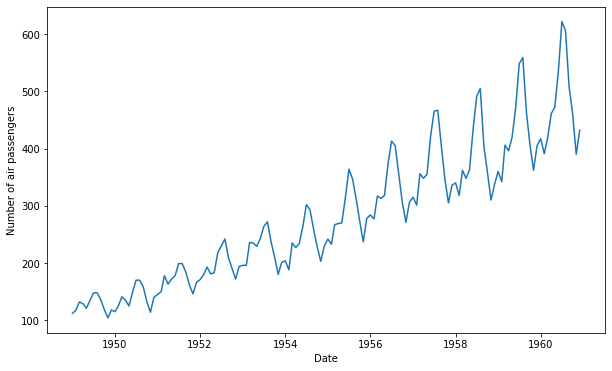

In [4]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)
plt.show()

In [12]:
help(df.resample)

Help on method resample in module pandas.core.frame:

resample(rule, axis=0, closed: 'str | None' = None, label: 'str | None' = None, convention: 'str' = 'start', kind: 'str | None' = None, loffset=None, base: 'int | None' = None, on=None, level=None, origin: 'str | TimestampConvertibleTypes' = 'start_day', offset: 'TimedeltaConvertibleTypes | None' = None) -> 'Resampler' method of pandas.core.frame.DataFrame instance
    Resample time-series data.
    
    Convenience method for frequency conversion and resampling of time series.
    The object must have a datetime-like index (`DatetimeIndex`, `PeriodIndex`,
    or `TimedeltaIndex`), or the caller must pass the label of a datetime-like
    series/index to the ``on``/``level`` keyword parameter.
    
    Parameters
    ----------
    rule : DateOffset, Timedelta or str
        The offset string or object representing target conversion.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Which axis to use for up- or down-sampli

(13, 1)


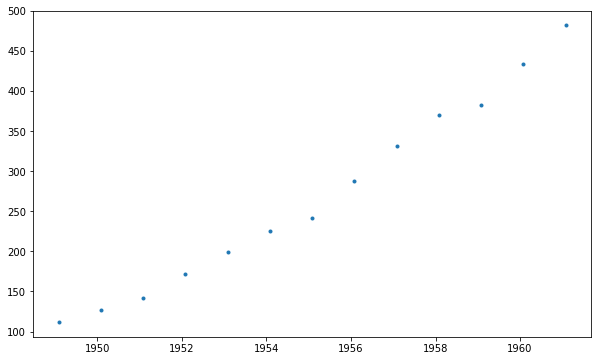

In [5]:
# resample into years bins and mean the values
# M is month end frequency
df_year = df.resample('12M').mean()
print(df_year.shape)
plt.figure()
plt.plot(df_year, '.')
plt.show()

Удаление пропущенных значений:

- заполнение средним значением
- заполнение последним значением
- линейная интерполяция




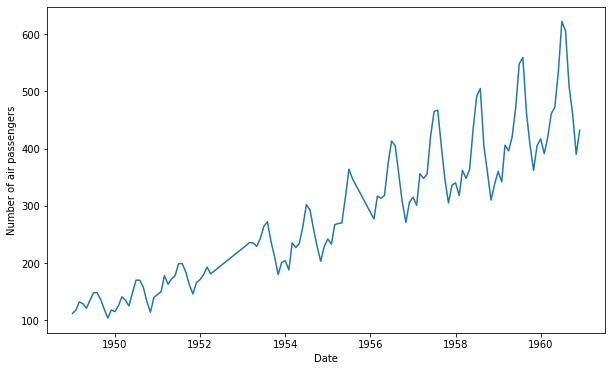

In [13]:
df_copy = df.copy()
df_copy[40:50] = float('nan')
df_copy[80:85] = float('nan')

# df_copy = df_copy.fillna(-100)

# fill with mean value
mean_val = df_copy.mean()
# df_copy = df_copy.fillna(mean_val)

# forward fill
# df_copy = df_copy.ffill()

# interpolate values
df_copy = df_copy.interpolate()

plt.figure()
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df_copy)
plt.show()

### 2. Предобработка и оценка стационарности

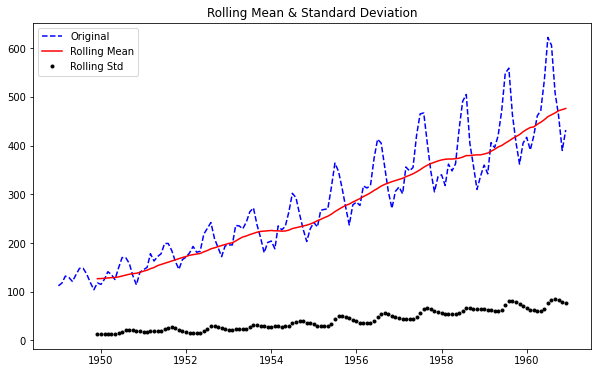

In [14]:
# Determine rolling statistics
rolmean = df.rolling(window=12).mean() # window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df.rolling(window=12).std()

#Plot rolling statistics
plt.figure()
plt.plot(df, '--', color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, '.', color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Стационарность:
 - const среднее значение и дисперсия
 - Критерий Дика-Фуллера

In [15]:
from statsmodels.tsa.stattools import adfuller
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
      

In [19]:
#Perform Augmented Dickey–Fuller test:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df.y, autolag='AIC')
print(f'Results of Dickey Fuller Test: ')
print(f'usedlag:{usedlag}')
print(f'p-value:{pvalue:.2f}')
print(f'ADF statistic:{adf:.2f}')
print(critical_values)


Results of Dickey Fuller Test: 
usedlag:13
p-value:0.99
ADF statistic:0.82
{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

**Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

**Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

- **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Способы приведения к стационарности:
 - преобразование (log, BoxCox)
 - дифференцирование

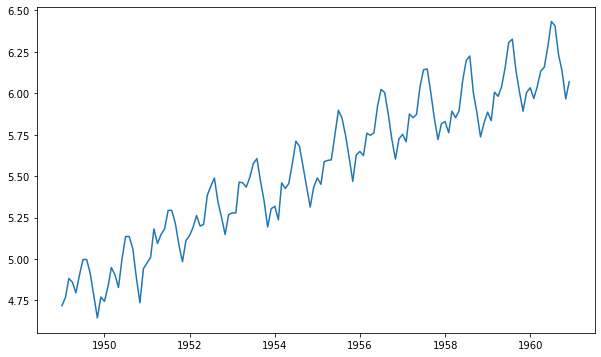

LOG p-value: 0.42


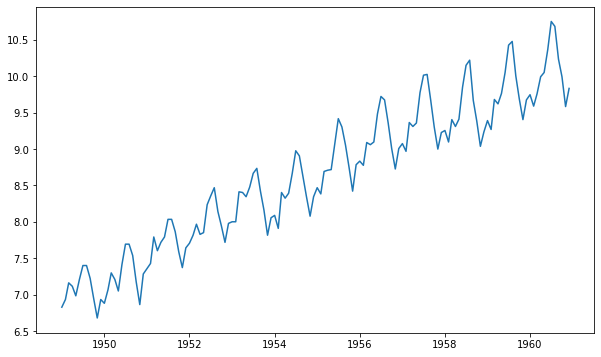

BoxCox p-value: 0.62
Lambda: 0.14802265137037945


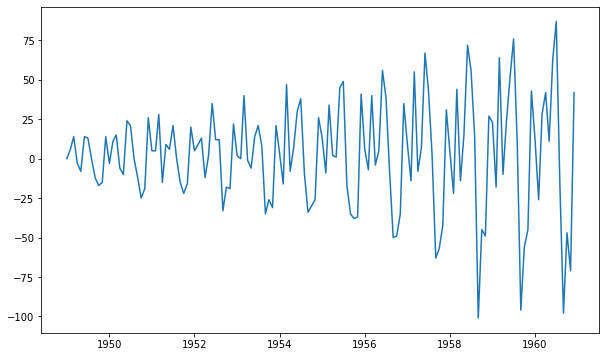

Diff p-value: 0.05


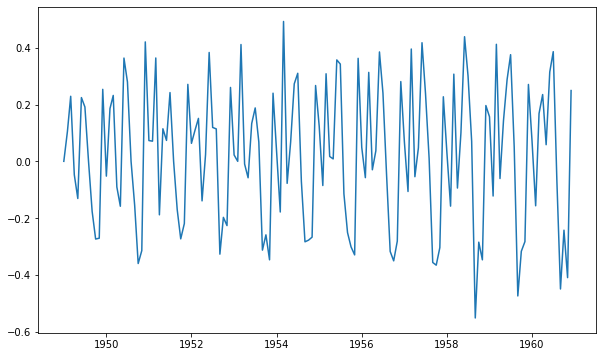

BoxCox + Diff p-value: 0.06


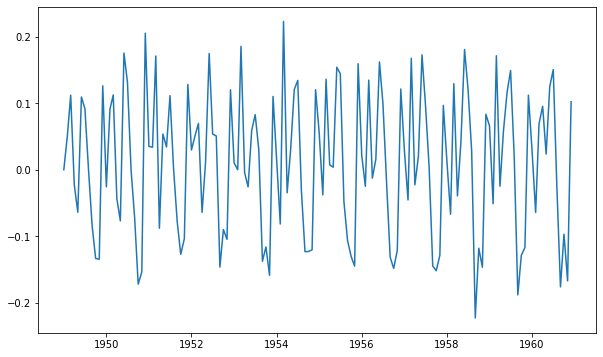

Log + Diff p-value: 0.08


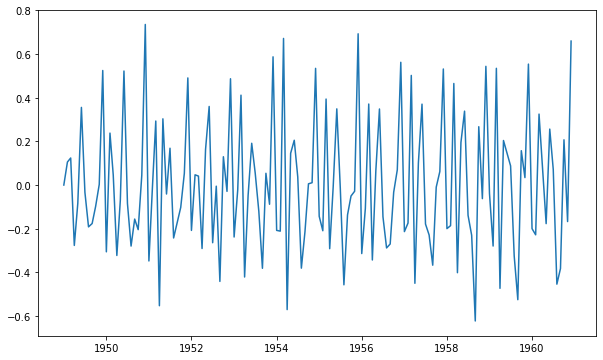

Log + Diff^2 p-value: 0.00


In [16]:
from scipy import stats

# log
df_log = df.copy()
df_log.y = np.log(df.y)
plt.plot(df_log)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_log.y, autolag='AIC')
print(f'LOG p-value: {pvalue:.2f}' )

# BoxCox
df_boxcox = df.copy()
df_boxcox.y, lmbda_boxcox = stats.boxcox(df.y)
plt.plot(df_boxcox)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_boxcox.y, autolag='AIC')
print(f'BoxCox p-value: {pvalue:.2f}' )
print(f'Lambda: {lmbda_boxcox}')

# diff
df_diff = df.copy()
df_diff.y = np.append([0], np.diff(df.y))
plt.plot(df_diff)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_diff.y, autolag='AIC')
print(f'Diff p-value: {pvalue:.2f}')

# boxcox + diff
df_diff_boxcox = df.copy()
df_diff_boxcox.y = np.append([0], np.diff(df_boxcox.y))
plt.plot(df_diff_boxcox)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_diff_boxcox.y, autolag='AIC')
print(f'BoxCox + Diff p-value: {pvalue:.2f}')

# log + diff
df_diff_log = df.copy()
df_diff_log.y = np.append([0], np.diff(df_log.y))
plt.plot(df_diff_log)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_diff_log.y, autolag='AIC')
print(f'Log + Diff p-value: {pvalue:.2f}')

# boxcox + diff^2
df_diff2_boxcox = df.copy()
df_diff2_boxcox.y = np.append([0], np.diff(df_diff_boxcox.y))
plt.plot(df_diff2_boxcox)
plt.show()
_, pvalue, _, _, _, _ = adfuller(df_diff2_boxcox.y, autolag='AIC')
print(f'Log + Diff^2 p-value: {pvalue:.2f}')

### 3. Метрики

Mean Squared Error: $MSE = \frac{1}{T}\sum\limits_{t}{(y_t - \hat{y}_t)^2}$

Root Mean Squared Error: $RMSE = \sqrt{MSE} = \sqrt{\frac{1}{T}\sum\limits_{t}{(y_t - \hat{y}_t)^2}}$

Mean Absolute Error: $MAE = \frac{1}{T}\sum\limits_{t}{\lvert{y_t - \hat{y}_t}\rvert}$

Mean Absolute Percentage Error: $MAPE = \frac{100\%}{T}\sum\limits_{t}{\lvert\frac{y_t - \hat{y}_t}{y_t}\rvert}$

Weighted Absolute Percentage Error: $WAPE = {\frac{\sum\limits_{t}{|y_t - \hat{y}_t|}}{\sum\limits_{t}y_t}}$

In [17]:
def rmse(y, y_hat):
    return np.sqrt(np.sum(np.square(y - y_hat)) / len(y))

# TODO: implement other 1-2 metrics

## 4. Построение модели ARIMA

$\Delta^d X_t = c + \sum\limits_{t=1}^p \Delta^d X_{t-i} + \sum\limits_{t=1}^q b_j \varepsilon_{t-i} + \varepsilon_{t}$

**ARIMA** = AutoRegressive + Integrated + Moving Average

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

- **Autocorrelation Function (ACF)**: Correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1. -> MA parameter is **q** significant lags
- **Partial Autocorrelation Function (PACF)**: Additional correlation explained by each successive lagged term -> AR parameter is **p** significant lags


RAW


/home/avalur/mkn_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


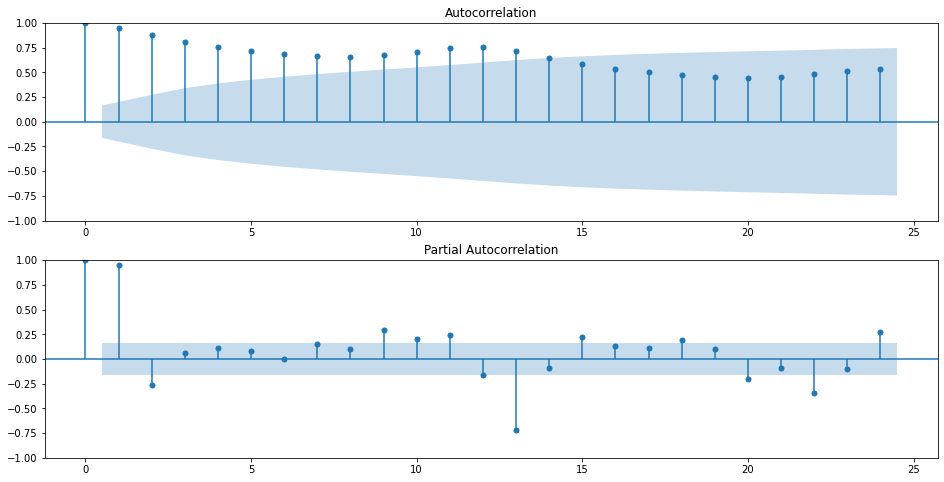

BoxCox + diff


/home/avalur/mkn_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


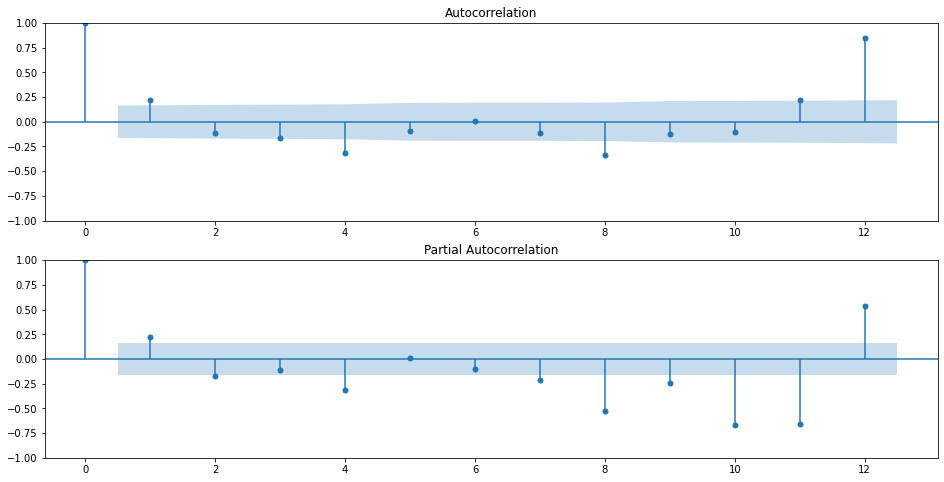

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

print("RAW")
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(df.y, lags=24, ax=ax[0])
plot_pacf(df.y, lags=24, ax=ax[1])
plt.show()

print("BoxCox + diff")
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(df_diff_boxcox.y,lags=12, ax=ax[0])
plot_pacf(df_diff_boxcox.y,lags=12, ax=ax[1])
plt.show()

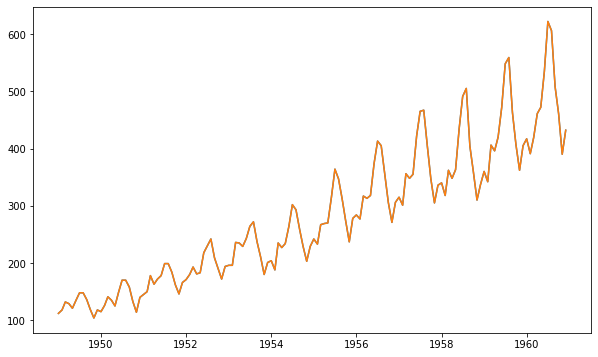

In [19]:
# Some inverse stuff

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

def invdiff(y_diff, y0):
    return np.cumsum(y_diff) + y0

inv_diff_boxcox = lambda y: invboxcox(invdiff(y, df_boxcox.y[0]), lmbda_boxcox)
inv_diff2_boxcox = lambda y: invboxcox(invdiff(invdiff(y, df_diff_boxcox.y[0]), df_boxcox.y[0]), lmbda_boxcox)
inv_boxcox = lambda y: invboxcox(y, lmbda_boxcox)

plt.plot(inv_diff2_boxcox(df_diff2_boxcox.y))
plt.plot(inv_boxcox(df_boxcox.y))
# plt.plot(df.y)
plt.show()


In [20]:
from statsmodels.tsa.arima.model import ARIMA

TEST_SIZE = 12 # a year
TRAIN_SIZE = len(df.y) - TEST_SIZE

df_input = df_boxcox.copy()

df_train = df_input.y[:TRAIN_SIZE]
df_test = df_input.y[TRAIN_SIZE:]

d = 1
inv_func = inv_diff_boxcox
params_pdq = (2, d, 2)

try:
    model_ARIMA = ARIMA(df_train, order=params_pdq).fit(
          # maxiter=500,
          # tol=1.e-6,
          # solver='lbfgs',  
                        # default is 'lbfgs' (limited memory
                        # Broyden-Fletcher-Goldfarb-Shanno).  Other choices are 'bfgs',
                        # 'newton' (Newton-Raphson), 'nm' (Nelder-Mead), 'cg' -
                        # (conjugate gradient), 'ncg' (non-conjugate gradient), and
                        # 'powell'.
      )
except:
  print("ERROR")

/home/avalur/mkn_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/avalur/mkn_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/avalur/mkn_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [21]:
TRAIN_SIZE

132

In [22]:
print(model_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  11.366
Date:                Sat, 09 Apr 2022   AIC                            -12.733
Time:                        12:49:42   BIC                              1.643
Sample:                    01-01-1949   HQIC                            -6.891
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1918      0.159      1.209      0.227      -0.119       0.503
ar.L2          0.3163      0.178      1.775      0.076      -0.033       0.666
ma.L1         -0.0308      0.107     -0.287      0.7

In [23]:
model_ARIMA.forecast()[0], df_input.y[TRAIN_SIZE]

(9.822026254796597, 9.745316815883442)

In [24]:
arima_predict = model_ARIMA.predict(start=TRAIN_SIZE, end=TRAIN_SIZE + TEST_SIZE - 1)
arima_predict_full = df_input.copy()
arima_predict_full.y[:TRAIN_SIZE] = df_diff_boxcox.y[:TRAIN_SIZE]
arima_predict_full.y[TRAIN_SIZE:] = arima_predict
inv_arima_predict_full = arima_predict_full.copy()
inv_arima_predict_full = inv_func(arima_predict_full.y)

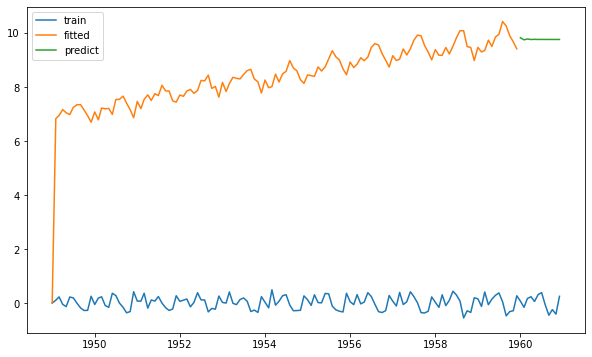

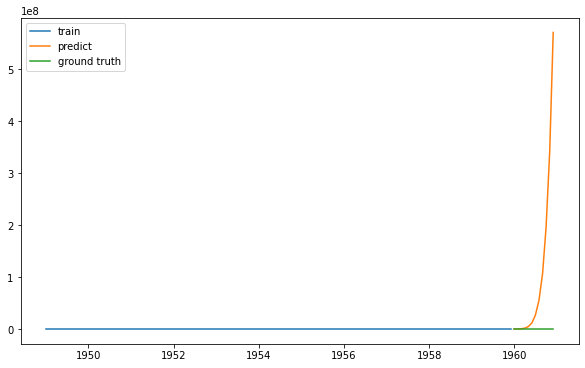

RMSE:  203313850.94663548


In [25]:
plt.figure()
plt.plot(df_diff_boxcox)
plt.plot(model_ARIMA.fittedvalues)
plt.plot(arima_predict_full[TRAIN_SIZE:])
plt.legend(['train', 'fitted', 'predict'])
plt.show()

plt.figure()
plt.plot(df.y[:TRAIN_SIZE])
plt.plot(inv_arima_predict_full[TRAIN_SIZE:])
plt.plot(df.y[TRAIN_SIZE:])
plt.legend(['train', 'predict', 'ground truth'])
plt.show()

print('RMSE: ', rmse(df.y[TRAIN_SIZE:], inv_arima_predict_full[TRAIN_SIZE:]))

### Задание 1.

Перебрать значения $p, q$ и выбрать наилучшую модель по критерию AIC, посчитать для неё RMSE и MAPE

### 5. Построение модели facebook Prophet

In [26]:
# !pip install pystan~=2.14
!pip install fbprophet

You should consider upgrading via the '/home/avalur/mkn_env/bin/python -m pip install --upgrade pip' command.


In [27]:
from fbprophet import Prophet
df_for_prophet = pd.DataFrame({'ds': df.index, 'y': df.y.values})
model_prophet = Prophet().fit(df_for_prophet[:TRAIN_SIZE])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.41026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       367.965    0.00189215       141.679   2.216e-05       0.001      142  LS failed, Hessian reset 
      99       368.079    2.9492e-05       69.7302       0.656       0.656      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       368.195    5.4452e-06       62.0005           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       368.195    7.9544e-09       72.3965      0.2416      0.2416      339   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [28]:
future = model_prophet.make_future_dataframe(periods=TEST_SIZE)

prophet_forecast = model_prophet.predict(future)
print(len(prophet_forecast))

144


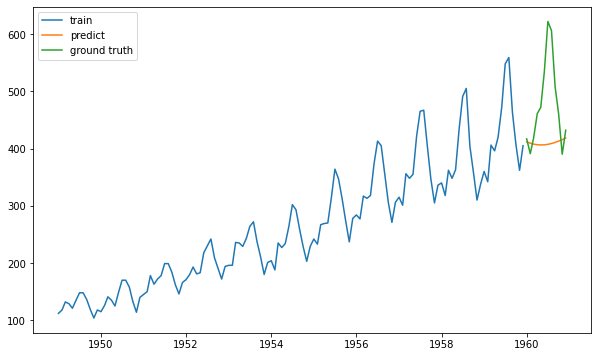

RMSE:  100.78023047670678


In [29]:
plt.figure()
plt.plot(df.y[:TRAIN_SIZE])
plt.plot(df.index[TRAIN_SIZE:], prophet_forecast['yhat'].values[TRAIN_SIZE:])
plt.plot(df.y[TRAIN_SIZE:])
plt.legend(['train', 'predict', 'ground truth'])
plt.show()

print('RMSE: ', rmse(df.y[TRAIN_SIZE:], prophet_forecast['yhat'].values[TRAIN_SIZE:]))

In [30]:
path = "example_wp_log_peyton_manning.csv"
df_for_prophet = pd.read_csv(path)
print(len(df_for_prophet))
df_for_prophet.tail()

model_prophet = Prophet().fit(df_for_prophet[:-30])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2905
Initial log joint probability = -15.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7897.48     0.0032023       145.011           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198        7911.6    0.00010402       188.574    9.09e-07       0.001      275  LS failed, Hessian reset 
     199       7911.61   8.00282e-05       77.5258           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235        7912.9   3.47046e-05        109.16   3.905e-07       0.001      363  LS failed, Hessian reset 
     299       7914.78     0.0118277       203.053           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7916.16   0.000114442       55.5618           1           1      570   
    Iter      log 

In [35]:
future = model_prophet.make_future_dataframe(periods=360)
prophet_forecast = model_prophet.predict(future)
print(len(prophet_forecast))

3235


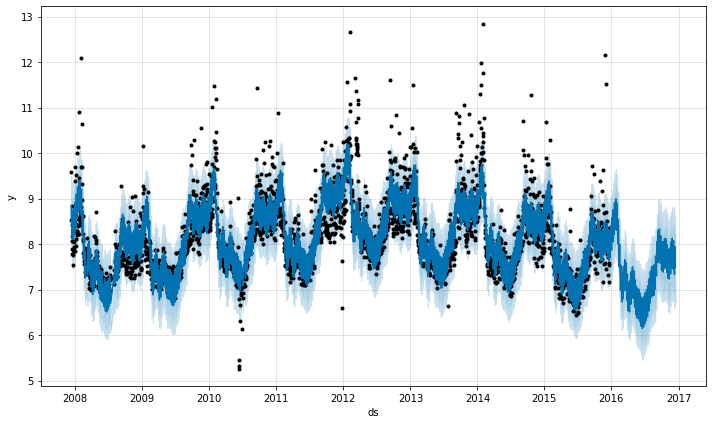

In [36]:
fig1 = model_prophet.plot(prophet_forecast)

## Задание 2

Обучить модель ARIMA для example_wp_log_peyton_manning.csv и сравнить качество с Prophet для последних 30 дней

## 6. Дополнительные материалы

https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting

https://habr.com/ru/company/ods/blog/323730/

https://www.kaggle.com/parulpandey/getting-started-with-time-series-using-pandas

https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://www.statsmodels.org/dev/examples/index.html#state-space-models
